In [2]:
from kaveh.behavioral.oculomotor.session import session
from kaveh.toolbox import find_file
from neo.io import Spike2IO
from matplotlib import pyplot as plt
import numpy as np



In [3]:
import os
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import sklearn.preprocessing as pp

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
buckley_files_correct_events = ['B082107_1340_List.smr', #yes adaptation in time window 1309 to 3235.5 s
'B090407_1526_List.smr', # yes
'B091208_1545_List.smr', # No done
'B091608_1208_List.smr', # No done
'B091707_1414_List.smr', # No done
'B091908_1_1500_List.smr', # No done
'B091908_2_1550_List.smr', # No done
'B093008_1149_List.smr', # No done
'B100308_2_1403_List.smr', # No done
'B101707_1333_List.smr', # yes
'B121407_1_1124_List.smr', # No done >> tuning doesn't match
'W091008_1241_List.smr', # No done
'W091208_1337_List.smr', # No done: bimodal cs-on
'W120108_1622_List.smr', # Yes --> actually no, the labled cs are nonsense; also weird saccades; needs more filtering
'W120208_1_1418_List.smr', # No done
'W120308_2_1714_List.smr', # Yes
'W120508_1_1420_List.smr', # No done
'W120508_2_1628_List.smr'] # No


f_index = 0
f_name = find_file(buckley_files_correct_events[f_index], '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt')
f_name_csv = find_file(buckley_files_correct_events[f_index]+'.pkl.csv', '../data/david_neurons')
print(f_name)
print(f_name_csv)

/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B082107/B082107_1340_List.smr
../data/david_neurons/B082107/B082107_1340_List.smr.pkl.csv


In [50]:
f_name = find_file('K45_1_ErrorDirectionTest.smr', '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/')
f_name_csv = find_file('K45_1_ErrorDirectionTest.smr'+'.pkl.csv', '../data/david_neurons')



In [54]:
f_name_csv

'../data/david_neurons/K45/error_direction/K45_1_ErrorDirectionTest.smr.pkl.csv'

In [51]:
neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]


In [52]:
# Load eye data
HE = seg.analogsignals[0].as_array()
t_HE = seg.analogsignals[0].times;

VE = seg.analogsignals[1].as_array()
t_VE = seg.analogsignals[1].times

HT = seg.analogsignals[2].as_array()
t_HT = seg.analogsignals[2].times

VT = seg.analogsignals[3].as_array()
t_VT = seg.analogsignals[3].times

fs = seg.analogsignals[0].sampling_rate
dt = seg.analogsignals[0].sampling_period


In [56]:
# Load cs times from csGUI csv files
import csv
t_signal = seg.analogsignals[-1].times

with open(f_name_csv, 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader), dtype=np.int64)

cs_indices = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
cs_times = t_signal[cs_indices]
cs_times.shape

(739,)

In [57]:
t_start = 0
t_end = 5000
mysess = session(HT[np.where(np.logical_and((t_HT > t_start), (t_HT <= t_end)))], t_HT[np.where(np.logical_and((t_HT > t_start), (t_HT <= t_end)))],
                 VT[np.where(np.logical_and((t_VT > t_start), (t_VT <= t_end)))], t_VT[np.where(np.logical_and((t_VT > t_start), (t_VT <= t_end)))],
                 HE[np.where(np.logical_and((t_HE > t_start), (t_HE <= t_end)))], t_HE[np.where(np.logical_and((t_HE > t_start), (t_HE <= t_end)))],
                 VE[np.where(np.logical_and((t_VE > t_start), (t_VE <= t_end)))], t_VE[np.where(np.logical_and((t_VE > t_start), (t_VE <= t_end)))], fs, dt)
mysess._cut_to_min_size()
mysess._calc_target_velocity()
mysess._calc_saccade_velocity()
mysess._detect_target_jumps()
mysess._detect_saccades()
mysess._calc_error_vectors()


In [58]:
# find inra-saccadic target jumps. For each saccade, check if that saccade is accompanied by a simultaneous target jump.
# If so, it is an intra-saccadic target_jump. 
# check 25 ms before and after the saccade onset and offset for the target jump onset and offset. if found, the target jump is intra-saccadic
import numpy as np
import quantities as pq
iss_range = pq.quantity.Quantity(0.050, 's')
iss_targets = []
iss_saccades = []
saccades_with_no_iss_target = []
for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
    iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
                                                             mysess.target_onset_times > son - iss_range), 
                                              np.logical_and(mysess.target_offset_times < soff + iss_range, 
                                                             mysess.target_offset_times > soff - iss_range)))[0])
    if iss_targets[-1].size != 0:
        iss_saccades.append(i)
    if iss_targets[-1].size == 0:
        saccades_with_no_iss_target.append(i)
        
iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

In [59]:
iss_multipeak_targets = []
for i, (son, soff) in enumerate(zip(mysess.multipeak_saccade_onsets, mysess.multpeak_saccade_offsets)):
    iss_multipeak_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
                                                             mysess.target_onset_times > son - iss_range), 
                                              np.logical_and(mysess.target_offset_times < soff + iss_range, 
                                                             mysess.target_offset_times > soff - iss_range)))[0])

iss_multipeak_targets = np.squeeze(np.array([isst[0] for isst in iss_multipeak_targets if isst.size != 0]))

In [60]:
non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), np.union1d(iss_targets, iss_multipeak_targets))

In [61]:
# calculate target vectors (target_offset_position - target_onset_position)
ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[non_iss_target_jumps]])
toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[non_iss_target_jumps]])

ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[non_iss_target_jumps]])
toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[non_iss_target_jumps]])

target_jump_H = toff_HT - ton_HT
target_jump_V = toff_VT - ton_VT

target_jump_dir = np.arctan2(target_jump_V, target_jump_H) * 180 / np.pi

target_jump_mag = np.linalg.norm(np.vstack((target_jump_H, target_jump_V)), axis = 0)




In [62]:
bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))

In [73]:
bin_ind [bin_ind == 8] = 0

In [72]:
np.arange(-180 + 22.5, 180, 45)

array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5])

In [74]:
np.unique(bin_ind)

array([0, 1, 2, 3, 4, 5, 6, 7])

<IPython.core.display.Javascript object>


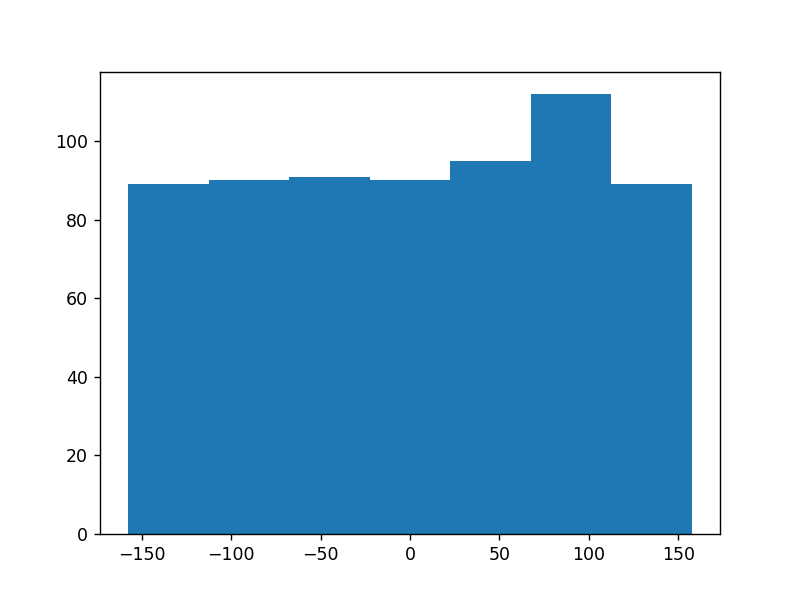

(array([ 89.,  90.,  91.,  90.,  95., 112.,  89.]),
 array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5]),
 <a list of 7 Patch objects>)

In [66]:
plt.figure()
plt.hist(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))

In [63]:
import quantities as pq

def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
    cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)


In [64]:
get_bin_cs_counts(0.200, mysess.target_offset_times[non_iss_target_jumps], bin_ind, np.array([1, 5]), cs_times)

(array([17, 18]), array([0.19101124, 0.18947368]), array([89, 95]))

In [123]:
bin_number = 7
saccade_response_delays_to_target_presentation = []
saccade_delays_target_offset_times = []
for toff in mysess.target_offset_times[non_iss_target_jumps][bin_ind == bin_number]:
    delay_to_next_saccade = mysess.saccade_onset_times[np.argmax(mysess.saccade_onset_times > toff)] - toff
    delay_to_next_target_jump = mysess.target_onset_times[non_iss_target_jumps][bin_ind == bin_number][np.argmax(mysess.target_onset_times[non_iss_target_jumps][bin_ind == bin_number] > toff)] - toff
    if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6:
        saccade_response_delays_to_target_presentation.append(delay_to_next_saccade)
        saccade_delays_target_offset_times.append(toff)

saccade_response_delays_to_target_presentation = np.squeeze(np.array(saccade_response_delays_to_target_presentation))
saccade_delays_target_offset_times = np.squeeze(np.array(saccade_delays_target_offset_times))

In [124]:
saccade_delays_target_offset_times =  pq.quantity.Quantity(saccade_delays_target_offset_times, 's')

In [159]:
bins = np.arange(0, np.max(saccade_response_delays_to_target_presentation), 0.020)
bin_ind_sac_delays = np.digitize(saccade_response_delays_to_target_presentation, bins = bins)
bins

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54])

In [160]:
bin_means = [saccade_response_delays_to_target_presentation[bin_ind_sac_delays == i].mean() for i in np.unique(bin_ind_sac_delays)]

In [161]:
(cs_counts, cs_probs, bin_sizes) = get_bin_cs_counts(0.200, saccade_delays_target_offset_times, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_times)

<IPython.core.display.Javascript object>


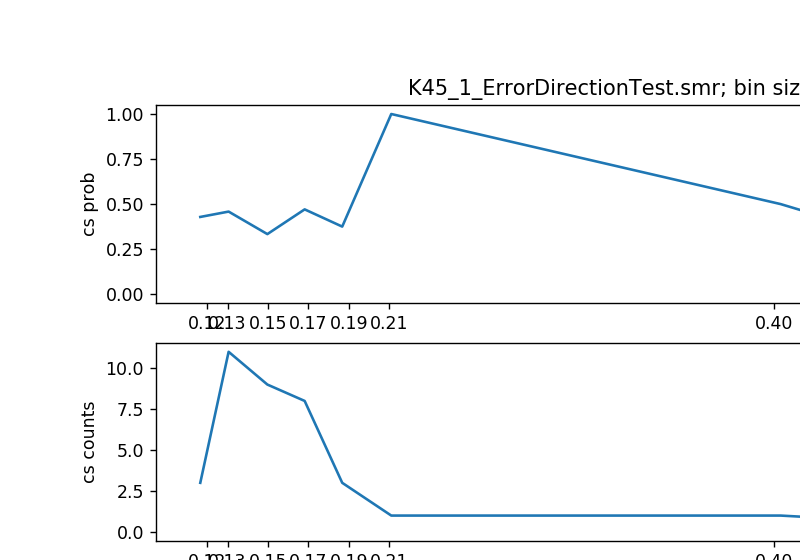

Text(0.5,0,u'bin mean delay (s)')

In [174]:
plt.figure(figsize=(10, 7))

plt.subplot(311)
plt.plot(bin_means,  cs_probs)
plt.xticks(np.round(bin_means,2))
plt.ylabel('cs prob')
plt.title('{}; bin size: {}'.format(os.path.basename(f_name), 0.020))

plt.subplot(312)
plt.plot(bin_means,  cs_counts)
plt.xticks(np.round(bin_means,2))
plt.ylabel('cs counts')

plt.subplot(313)
plt.plot(bin_means,  bin_sizes)
plt.xticks(np.round(bin_means,2))
plt.ylabel('bin size')
plt.xlabel('bin mean delay (s)')

# plt.ylabel('prob of cs in 0.250 after target present')

In [175]:
plt.savefig('../data/plots/Saliency_stuff/cs_prob_with_repect_to_delay_bin_0.020.png')

<IPython.core.display.Javascript object>


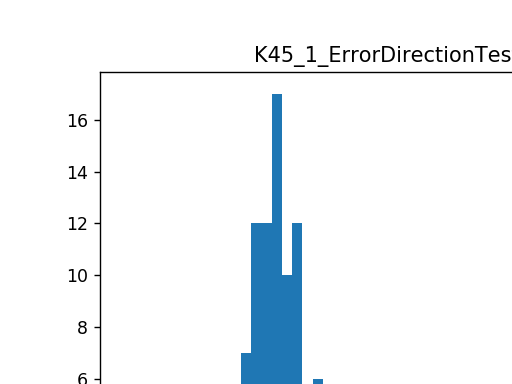

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 12.,
        12., 17., 10., 12.,  5.,  6.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55]),
 <a list of 55 Patch objects>)

In [142]:
plt.figure()
plt.hist(saccade_response_delays_to_target_presentation, bins = np.arange(0, np.max(saccade_response_delays_to_target_presentation), 0.01))

In [144]:
plt.xlabel('delay of saccade response to target presentaion')
plt.title(os.path.basename(f_name))
plt.savefig('../data/plots/Saliency_stuff/hist_of_saccade_response_delays.png')

<IPython.core.display.Javascript object>


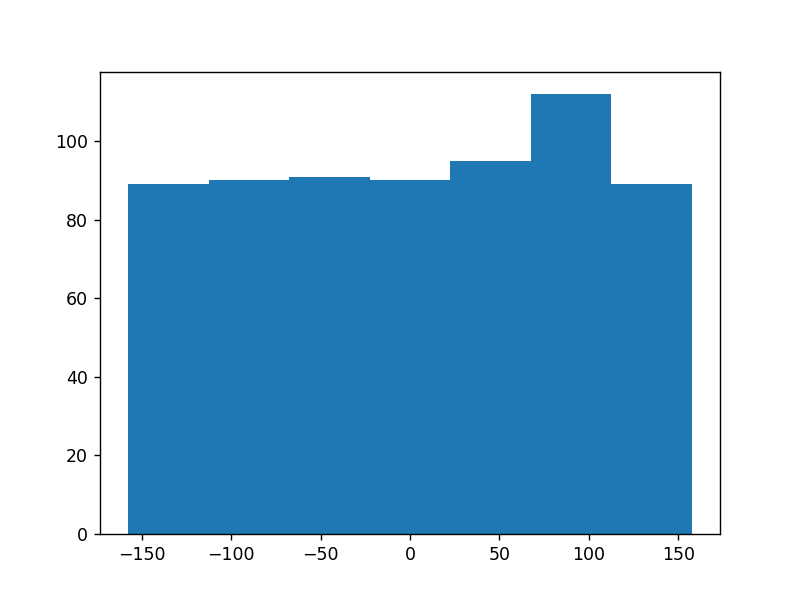

(array([ 89.,  90.,  91.,  90.,  95., 112.,  89.]),
 array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5]),
 <a list of 7 Patch objects>)

In [134]:
plt.figure()
plt.hist(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))


<IPython.core.display.Javascript object>


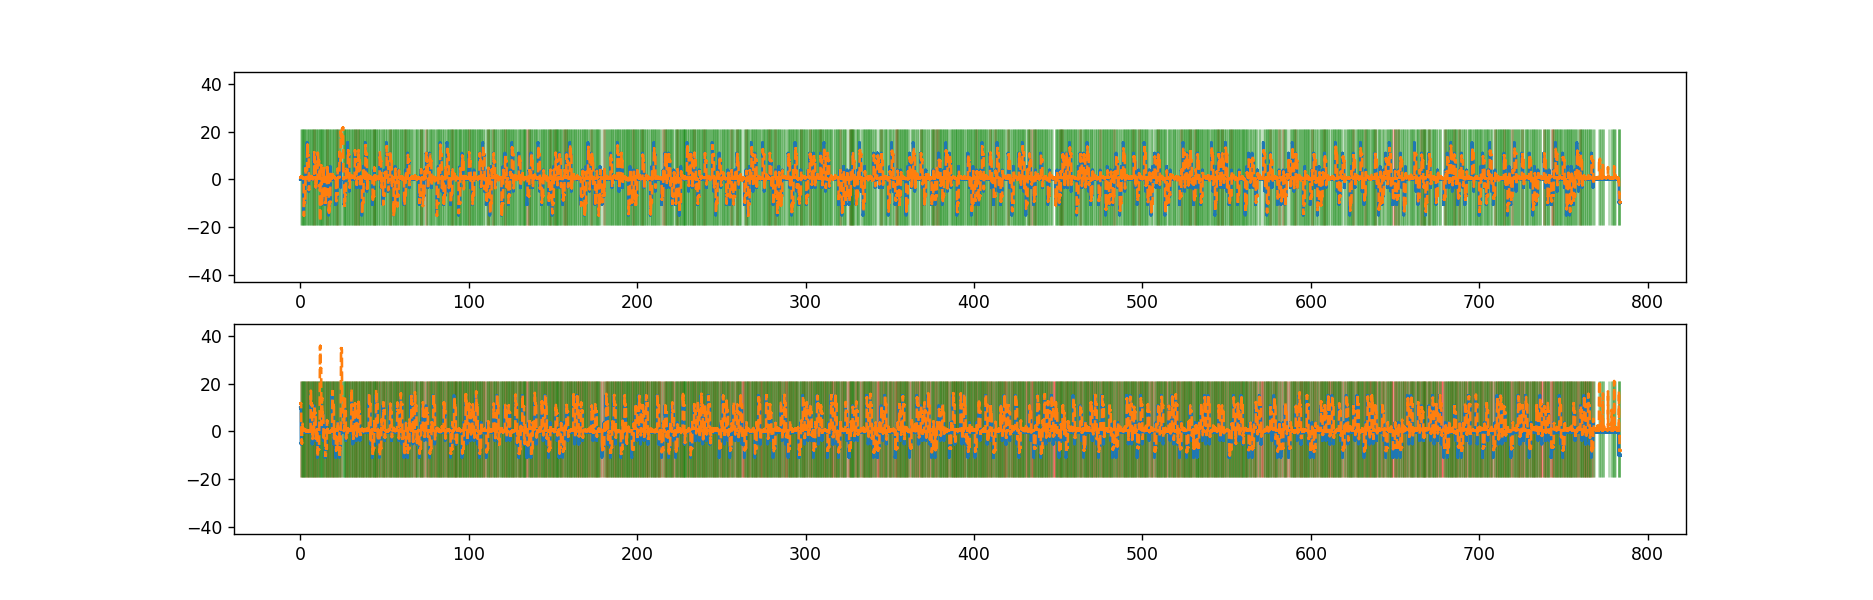

In [145]:
import gc
gc.collect()

plt.figure()
ax1 = plt.subplot(211)
plt.plot(t_HT, HT)
plt.plot(t_HE, HE, '--')
plt.eventplot(mysess.target_onset_times[non_iss_target_jumps][bin_ind == 5], linelengths=40, colors='r', alpha = 0.3)
plt.eventplot(mysess.saccade_onset_times, linelengths=40, color = 'g', alpha = 0.3)

ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.plot(t_VT, VT)
plt.plot(t_VE, VE, '--')
plt.eventplot(mysess.target_onset_times[non_iss_target_jumps], linelengths=40, colors='r', alpha = 0.3)
plt.eventplot(mysess.saccade_onset_times, linelengths=40, color = 'g', alpha = 0.3)

plt.show()

In [140]:
# saving mysess
output_fn = f_name_csv + '.session.pkl'
with open(output_fn, 'wb') as output:
    print('writing {} ...'.format(output_fn))
    pickle.dump(mysess, output, pickle.HIGHEST_PROTOCOL)


writing ../data/david_neurons/K45/error_direction/K45_1_ErrorDirectionTest.smr.pkl.csv.session.pkl ...
